# One possible "solution" for the project/homework

In [1]:
from brian2 import *
%matplotlib inline

/mnt/data/anaconda2/envs/brian_tutorial/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
start_scope()
tau = 10*ms
sigma = 0.5
N_E = 400
N_I = 100
tau_e = 50*ms
tau_i = 5*ms
w_ei = 5/N_I
w_ie = 1./N_E
w_ii = 1/N_I
theta_stim_1 = 0
theta_stim_2 = pi
sigma_stim = pi/8
strength_stim_1 = 0
strength_stim_2 = 0
exc_neurons = NeuronGroup(N_E, '''dv/dt = (-v + I_ee + I_ei + I_stim_1 + I_stim_2)/tau + sigma*xi*tau**-0.5: 1
                                  # There are now two stimuli 
                                  stimulus_diff_1 = (theta - theta_stim_1 + pi)%(2*pi) - pi : radian
                                  stimulus_diff_2 = (theta - theta_stim_2 + pi)%(2*pi) - pi : radian
                                  I_stim_1 = strength_stim_1*exp(-stimulus_diff_1**2/(2*sigma_stim**2)) : 1
                                  I_stim_2 = strength_stim_2*exp(-stimulus_diff_2**2/(2*sigma_stim**2)) : 1
                                  # Synapses are modeled as exponentially decaying currents
                                  dI_ee/dt = -I_ee/tau_e : 1
                                  dI_ei/dt = -I_ei/tau_i : 1
                                  theta : radian (constant)''', threshold='v>1', reset='v=0',
                         method='euler', refractory=2*ms)
exc_neurons.v = 'rand()*0.5'
exc_neurons.theta = '-pi + 1.0*i/N_E*2*pi'

E_to_E = Synapses(exc_neurons, exc_neurons, 'w: 1', on_pre='I_ee += w')
E_to_E.connect(p=0.5)  # All-to-all connections with 50% probability for each pair
sigma_struct = pi/8
J_global = 0.00055
J_selective = .0075*1.5
# Synaptic strength depends on difference between preferred stimuli – neurons preferring similar stimuli
# connect more strongly to each other
E_to_E.w = 'J_global + J_selective*exp(-((theta_pre - theta_post + pi)%(2*pi) - pi)**2/(2*sigma_struct**2))'

# Inhibitory population
inh_neurons = NeuronGroup(N_I, '''dv/dt = (-v + I_ie + I_ii)/(5*ms) + sigma*xi*tau**-0.5: 1
                                  dI_ie/dt = -I_ie/tau_e : 1
                                  dI_ii/dt = -I_ii/tau_i : 1''', threshold='v>1', reset='v=0',
                         method='euler', refractory=1*ms)
inh_neurons.v = 'rand()*0.5'

# Synaptic connections (all unspecific)
I_to_I = Synapses(inh_neurons, inh_neurons, on_pre='I_ii -= w_ii')
I_to_I.connect(p=0.5)
I_to_E = Synapses(inh_neurons, exc_neurons, on_pre='I_ei -= w_ei')
I_to_E.connect(p=0.5)
E_to_I = Synapses(exc_neurons, inh_neurons, on_pre='I_ie += w_ie')
E_to_I.connect(p=0.5)

exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)

run(500*ms, report='text')

# Stimulus 1 is slightly stronger
strength_stim_1 = .8
strength_stim_2 = .6
run(1000*ms, report='text')

strength_stim_1 = 0
strength_stim_2 = 0
run(1000*ms, report='text')

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
Starting simulation at t=0.5 s for a duration of 1. s
1. s (100%) simulated in 1s
Starting simulation at t=1.5 s for a duration of 1. s
1. s (100%) simulated in 1s


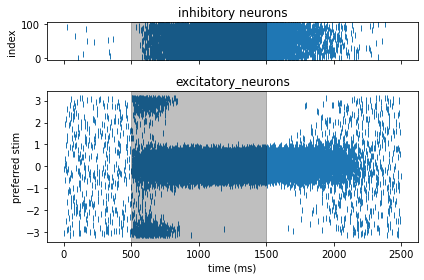

In [3]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 4]}, sharex=True)
ax[0].plot(inh_mon.t/ms, inh_mon.i, '|');
ax[0].set(title='inhibitory neurons', ylabel='index')
ax[1].plot(exc_mon.t/ms, exc_neurons.theta[exc_mon.i], '|');
ax[1].set(title='excitatory_neurons', ylabel='preferred stim', xlabel='time (ms)')
# Mark region where stimulus is presented
ax[0].axvspan(500, 1500, color='black', alpha=0.25, zorder=100)
ax[1].axvspan(500, 1500, color='black', alpha=0.25, zorder=100)
fig.tight_layout()

The stronger stimulus gets "selected" and suppresses the weaker stimulus. After switching off both stimuli, the activity is sustained for about 500ms.